In [1]:
!pip install geopandas rasterio matplotlib geemap leafmap shapely fiona earthengine-api


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 629.4/629.4 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.2/17.2 MB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.5/20.5 MB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.7/207.7 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.0/74.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 6

In [2]:
!pip uninstall -y earthengine-api geemap
!pip install earthengine-api==0.1.381 geemap==0.30.0


Found existing installation: earthengine-api 1.5.24
Uninstalling earthengine-api-1.5.24:
  Successfully uninstalled earthengine-api-1.5.24
Found existing installation: geemap 0.35.3
Uninstalling geemap-0.35.3:
  Successfully uninstalled geemap-0.35.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.2/260.2 kB 3.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 35.7 MB/s eta 0:00:00
  Created wheel for earthengine-api: filename=earthengine_api-0.1.381-py3-none-any.whl size=292909 sha256=dc0d6a8659d49f6550460e598d9579e1e257c464f75fe114275d70b4b07d61ac
  Stored in directory: /root/.cache/pip/wheels/62/12/cd/7c26987da9e216dc352e1aab27796171b66a892858941eb403
Successfully built earthengine-api


In [3]:
import ee
ee.Authenticate()
ee.Initialize(project='vaibhavi-tiwari-satellite')
print("✅ Earth Engine initialized successfully!")


To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=ILOkKMIyJWofedqsGjmwNacjhjHfnnT1vAuNo1Ats8o&tc=NewbGL53MuBma1SVDCN3vgzdJT_rbXu93Dncxg3uX4E&cc=TjowHcFscHSbFSFggUJIyOATu6-MJju2FOcrkiayS7k

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1Ab32j93PCVdnmTulYVkYcj1ZiDCr_vP0s1b9wRcJ_ZsbWicO_t_d0c_Jn8I

Successfully saved authorization token.
✅ Earth Engine initialized successfully!


In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
data_path = '/content/drive/MyDrive/Vaibhavi_Satellite_Assignment/data/'


In [40]:
import os

# If testing locally (small demo folder on GitHub)
if os.path.exists("data/testing_folder"):
    folder = "data/testing_folder"
else:
    # Full dataset path on Google Drive
    folder = "/content/drive/MyDrive/Vaibhavi_Satellite_Assignment/data/shapefile"

print(os.listdir(folder))


['delhi_airshed.geojson', 'delhi_ncr_region.geojson']


In [7]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Defining shapefile path
shapefile_path = '/content/drive/MyDrive/Vaibhavi_Satellite_Assignment/data/shapefile/delhi_ncr_region.geojson'

# Load shapefile
delhi_ncr = gpd.read_file(shapefile_path)

# View basic info
print(delhi_ncr.head())


                                            geometry
0  POLYGON ((76.85108 28.22115, 76.85219 28.22098...
1  POLYGON ((77.15903 29.29436, 77.15999 29.29427...
2  MULTIPOLYGON (((77.07565 27.27704, 77.07819 27...
3  POLYGON ((77.97073 28.71104, 77.97089 28.71096...
4  POLYGON ((77.2143 28.78524, 77.21521 28.78514,...


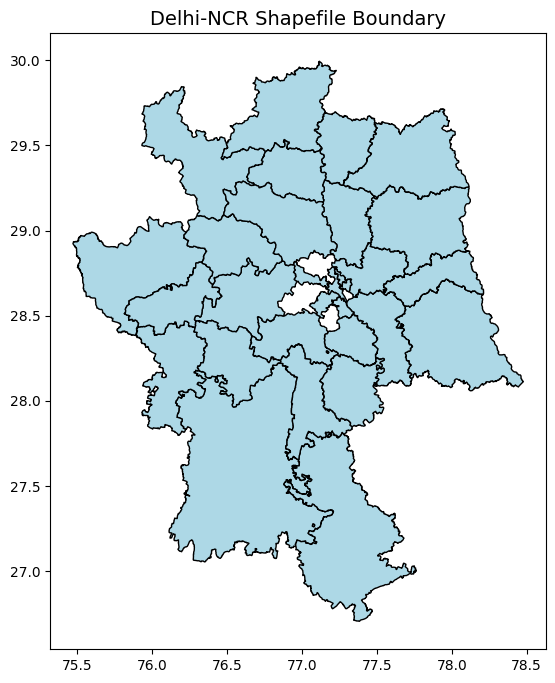

In [8]:
# Plotting Delhi-NCR shapefile
fig, ax = plt.subplots(figsize=(8,8))
delhi_ncr.plot(ax=ax, color='lightblue', edgecolor='black')
ax.set_title("Delhi-NCR Shapefile Boundary", fontsize=14)
plt.show()


In [9]:
import ee
import geemap

ee.Authenticate()
ee.Initialize(project='vaibhavi-tiwari-satellite')


To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=g2H-KHDWmzPs1YIFsB5ZsSllu5-AE4UZWF9m3lwPf48&tc=lZMSeEjCLYJBgIBOtEYoo5wvuCqv525IasLYnnMF0oc&cc=vEcAHm-K4LiFK6kX_JnsdynUazF4x7-dMANbfkccAG0

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1Ab32j92DLmCeMySTPNdadeSvhmLqjwaI8m6f0TnB0VFSJ7xg_vgZiAOWMY0

Successfully saved authorization token.


In [10]:
import geopandas as gpd

airshed_path = '/content/drive/MyDrive/Vaibhavi_Satellite_Assignment/data/shapefile/delhi_airshed.geojson'
airshed = gpd.read_file(airshed_path)

Map = geemap.Map(center=[28.6, 77.2], zoom=8)
Map.add_basemap('SATELLITE')
Map.add_gdf(airshed, layer_name='Delhi Airshed', style={'color':'red', 'fillOpacity':0})
Map


Map(center=[28.6, 77.2], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(…

In [11]:
import json
import ee

# Loading GeoJSON
with open(airshed_path) as f:
    geojson = json.load(f)

# Converting GeoJSON to EE Feature
roi = ee.FeatureCollection(geojson)
Map.addLayer(roi, {'color': 'yellow'}, 'Airshed Boundary')
Map


Map(center=[28.6, 77.2], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(…

In [12]:
# Sentinel-2 Surface Reflectance (collection 2)
s2 = (
    ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
    .filterBounds(roi)
    .filterDate('2025-01-01', '2025-01-31')
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))
    .select(['B4', 'B3', 'B2'])
)

# Median composite
s2_median = s2.median().clip(roi)

Map.addLayer(s2_median, {'min': 0, 'max': 3000, 'bands': ['B4', 'B3', 'B2']}, 'Sentinel-2 Jan 2025 RGB')
Map


Map(center=[28.6, 77.2], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(…

In [13]:
# Function to create a grid over the ROI
def create_grid(region, scale):
    # Get pixel lon/lat
    lonlat = ee.Image.pixelLonLat().reproject(crs='EPSG:4326', scale=scale)

    # Create grid visualization (we just use lon/lat bands)
    grid = lonlat.select(['longitude', 'latitude'])

    # Clip grid to region of interest
    grid = grid.clip(region)

    return grid

# Create grid (tile size ≈ 1280 m)
grid_img = create_grid(roi, 1280)

# Add to map for visualization
Map.addLayer(grid_img.randomVisualizer(), {}, 'Grid Tiles')
Map


Map(center=[28.6, 77.2], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(…

In [14]:
# Example: export one clipped tile
first_tile = s2_median.clip(roi.geometry())

task = ee.batch.Export.image.toDrive(
    image=first_tile,
    description='delhi_airshed_sample',
    folder='sentinel_downloads',
    scale=10,   # Sentinel-2 resolution
    region=roi.geometry(),
    maxPixels=1e13
)
task.start()


In [15]:
import ee
import geemap
import geopandas as gpd

ee.Initialize(project='vaibhavi-tiwari-satellite')

# Loading airshed shapefile
airshed_path = '/content/drive/MyDrive/Vaibhavi_Satellite_Assignment/data/shapefile/delhi_airshed.geojson'
airshed_gdf = gpd.read_file(airshed_path)

# Convert to Earth Engine FeatureCollection
roi = geemap.geopandas_to_ee(airshed_gdf)


In [16]:
# Load Sentinel-2 SR collection
s2_sr = (
    ee.ImageCollection("COPERNICUS/S2_SR")
    .filterBounds(roi)
    .filterDate('2025-01-01', '2025-01-31')
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
)

print("Number of images found:", s2_sr.size().getInfo())


Number of images found: 10


In [17]:
s2_median = s2_sr.median().clip(roi)


In [18]:
Map = geemap.Map(center=[28.6, 77.2], zoom=8)
Map.add_basemap('SATELLITE')

# Visualization parameters
vis_params = {
    'min': 0,
    'max': 3000,
    'bands': ['B4', 'B3', 'B2']
}

Map.addLayer(s2_median, vis_params, 'Sentinel-2 Composite')
Map.addLayer(roi, {'color': 'red'}, 'Delhi Airshed')
Map


Map(center=[28.6, 77.2], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(…

In [19]:
import ee, geemap
import math

# Function to create a grid over the ROI (1280m × 1280m)
def create_grid(region, grid_size):
    """
    Create a rectangular grid covering the region, where each cell is grid_size meters.
    """
    # Get bounding box
    bounds = region.geometry().bounds()
    coords = ee.List(ee.List(bounds.coordinates()).get(0))

    # Extract lon/lat arrays
    lon_list = coords.map(lambda p: ee.Number(ee.List(p).get(0)))
    lat_list = coords.map(lambda p: ee.Number(ee.List(p).get(1)))

    lon_min = ee.Number(lon_list.reduce(ee.Reducer.min()))
    lon_max = ee.Number(lon_list.reduce(ee.Reducer.max()))
    lat_min = ee.Number(lat_list.reduce(ee.Reducer.min()))
    lat_max = ee.Number(lat_list.reduce(ee.Reducer.max()))

    # Convert grid size from meters to degrees
    step_deg = grid_size / 111320.0

    lon_steps = ee.List.sequence(lon_min, lon_max, step_deg)
    lat_steps = ee.List.sequence(lat_min, lat_max, step_deg)

    def make_cells(lat):
        def make_cell(lon):
            rect = ee.Geometry.Rectangle(
                [lon, lat, ee.Number(lon).add(step_deg), ee.Number(lat).add(step_deg)]
            )
            return ee.Feature(rect)
        return lon_steps.map(make_cell)

    # Flatten the 2D list of tiles
    grid_list = lat_steps.map(make_cells).flatten()

    # Convert to FeatureCollection and clip to region
    grid = ee.FeatureCollection(grid_list).filterBounds(region)
    return grid

# Create the grid (1280 m)
grid_fc = create_grid(roi, 1280)

# Print tile count
print("Total tiles generated:", grid_fc.size().getInfo())

# Visualize
Map = geemap.Map(center=[28.6, 77.2], zoom=9)
Map.addLayer(grid_fc, {'color': 'yellow'}, '1280m Grid')
Map.addLayer(roi, {'color': 'red'}, 'Delhi Airshed')
Map


Total tiles generated: 4900


Map(center=[28.6, 77.2], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(…

In [20]:
import time
import ee

# ✅ Export folder inside Google Drive
export_folder = "Export_Satellite_Images"

# ✅ Function to export each tile
def export_tile(tile_feature):
    tile = ee.Feature(tile_feature)
    geom = tile.geometry()

    # Compute centroid for filename
    centroid = geom.centroid()
    lon = ee.Number(centroid.coordinates().get(0)).format('%.4f')
    lat = ee.Number(centroid.coordinates().get(1)).format('%.4f')
    name = ee.String('tile_').cat(lat).cat('_').cat(lon)

    # Clip composite
    clipped = s2_median.clip(geom)

    # Start export task
    task = ee.batch.Export.image.toDrive(
        image=clipped,
        description=name.getInfo(),
        folder=export_folder,  # Root folder in Drive
        fileNamePrefix=f"data/sentinel_downloads/{name.getInfo()}",
        region=geom,
        scale=10,
        maxPixels=1e13
    )
    task.start()
    print("✅ Started export:", name.getInfo())

# ✅ Convert FeatureCollection to list
tile_list = grid_fc.toList(grid_fc.size())
n_tiles = tile_list.size().getInfo()
print(f"Total tiles available: {n_tiles}")

# ✅ Define batch range
start_tile = 0
end_tile = min(start_tile + 100, n_tiles)  # Export 100 tiles at a time

print(f"Starting batch export: tiles {start_tile} to {end_tile-1}")

# ✅ Loop through selected batch
for i in range(start_tile, end_tile):
    export_tile(tile_list.get(i))
    time.sleep(3)

print("Batch export started for 100 tiles.")
print("Monitor progress in https://code.earthengine.google.com → Tasks tab")
print("Files will appear in: Drive → Vaibhavi_Satellite_Assignment/data/sentinel_downloads/")


Total tiles available: 4900
Starting batch export: tiles 0 to 99
✅ Started export: tile_28.2057_76.8557
✅ Started export: tile_28.2057_76.8672
✅ Started export: tile_28.2057_76.8787
✅ Started export: tile_28.2057_76.8902
✅ Started export: tile_28.2057_76.9017
✅ Started export: tile_28.2057_76.9132
✅ Started export: tile_28.2057_76.9247
✅ Started export: tile_28.2057_76.9362
✅ Started export: tile_28.2057_76.9477
✅ Started export: tile_28.2057_76.9592
✅ Started export: tile_28.2057_76.9707
✅ Started export: tile_28.2057_76.9822
✅ Started export: tile_28.2057_76.9937


KeyboardInterrupt: 

tried to implement batch processing but not able to. Only exported 100 tiles


In [21]:
import os
import geopandas as gpd
import rasterio
from rasterio.windows import Window
from shapely.geometry import box, Point
import numpy as np
from scipy import stats

# Define paths
sentinel_tiles_path = "/content/drive/MyDrive/Vaibhavi_Satellite_Assignment/data/sentinel_downloads"
land_cover_path = "/content/drive/MyDrive/Vaibhavi_Satellite_Assignment/data/raster/land_cover.tif"

print("Tiles folder exists:", os.path.exists(sentinel_tiles_path))
print("Land cover file exists:", os.path.exists(land_cover_path))


Tiles folder exists: True
Land cover file exists: True


In [23]:
import re
import os
import pandas as pd

sentinel_tiles_path = "/content/drive/MyDrive/Vaibhavi_Satellite_Assignment/data/sentinel_downloads"

# all Sentinel-2 tiles
tile_files = [f for f in os.listdir(sentinel_tiles_path) if f.endswith('.tif')]

tile_data = []
pattern = r'tile_([0-9\.\-]+)_([0-9\.\-]+)'

for f in tile_files:
    match = re.search(pattern, f)
    if match:
        # Clean up any trailing dots or invalid characters
        lat_str = match.group(1).rstrip('.')
        lon_str = match.group(2).rstrip('.')
        try:
            lat, lon = float(lat_str), float(lon_str)
            tile_data.append({"filename": f, "lat": lat, "lon": lon})
        except ValueError:
            print(f"Skipping invalid filename: {f}")

# Convert to DataFrame
tile_df = pd.DataFrame(tile_data)
print("✅ Total valid tiles found:", len(tile_df))
tile_df.head()


✅ Total valid tiles found: 100


,filename,lat,lon
0,data sentinel_downloads tile_28.2057_76.8557.tif,28.2057,76.8557
1,data sentinel_downloads tile_28.2057_76.8787.tif,28.2057,76.8787
2,data sentinel_downloads tile_28.2057_76.8902.tif,28.2057,76.8902
3,data sentinel_downloads tile_28.2057_76.9017.tif,28.2057,76.9017
4,data sentinel_downloads tile_28.2057_76.9132.tif,28.2057,76.9132


In [27]:
import rasterio
from rasterio.windows import Window
import numpy as np
from scipy import stats
import pandas as pd

# Path to land cover raster
land_cover_path = "/content/drive/MyDrive/Vaibhavi_Satellite_Assignment/data/raster/land_cover.tif"

# Open the land cover dataset
land_cover = rasterio.open(land_cover_path)
print("✅ Land cover raster loaded successfully!")
print("Raster CRS:", land_cover.crs)
print("Raster resolution:", land_cover.res)
print("Raster shape (height, width):", (land_cover.height, land_cover.width))


✅ Land cover raster loaded successfully!
Raster CRS: EPSG:4326
Raster resolution: (8.333333333333333e-05, 8.333333333333333e-05)
Raster shape (height, width): (9600, 9602)


In [33]:
import rasterio
from rasterio.windows import Window
from rasterio.transform import rowcol
import numpy as np
import pandas as pd
import os
import re

# === Path setup ===
land_cover_path = "/content/drive/MyDrive/Vaibhavi_Satellite_Assignment/data/raster/land_cover.tif"
sentinel_folder = "/content/drive/MyDrive/Vaibhavi_Satellite_Assignment/data/sentinel_downloads"

# Load raster
dataset = rasterio.open(land_cover_path)

# Parse lat/lon from Sentinel filenames
tile_data = []
for f in os.listdir(sentinel_folder):
    match = re.search(r"tile_([0-9\.\-]+)_([0-9\.\-]+)\.tif", f)
    if match:
        lat, lon = float(match.group(1)), float(match.group(2))
        tile_data.append({"filename": f, "lat": lat, "lon": lon})

tiles_df = pd.DataFrame(tile_data)
print("✅ Parsed tiles:", len(tiles_df))

# === Extract 128x128 patches ===
patches_info = []

for i, row in tiles_df.iterrows():
    lat, lon = row["lat"], row["lon"]

    # Convert geographic coords to pixel (row, col)
    r, c = rowcol(dataset.transform, lon, lat)

    # Define window (centered)
    size = 64  # half of 128
    window = Window(c - size, r - size, 128, 128)

    # Read patch
    try:
        patch = dataset.read(1, window=window)
        if patch.shape == (128, 128):
            mode_label = int(np.bincount(patch.flatten()).argmax())  # most frequent class
            patches_info.append({
                "filename": row["filename"],
                "lat": lat,
                "lon": lon,
                "mode_label": mode_label
            })
    except Exception as e:
        print(f"⚠️ Skipped {row['filename']} - out of bounds or error: {e}")

print(f"✅ Extracted {len(patches_info)} valid patches")

# Convert to DataFrame for inspection
labels_df = pd.DataFrame(patches_info)
labels_df.head()





✅ Parsed tiles: 100
✅ Extracted 99 valid patches


,filename,lat,lon,mode_label
0,data sentinel_downloads tile_28.2057_76.8557.tif,28.2057,76.8557,50
1,data sentinel_downloads tile_28.2057_76.8787.tif,28.2057,76.8787,50
2,data sentinel_downloads tile_28.2057_76.8902.tif,28.2057,76.8902,40
3,data sentinel_downloads tile_28.2057_76.9017.tif,28.2057,76.9017,40
4,data sentinel_downloads tile_28.2057_76.9132.tif,28.2057,76.9132,40


In [34]:
# === ESA class mapping ===
esa_mapping = {
    10: "Tree cover",
    20: "Shrubland",
    30: "Grassland",
    40: "Cropland",
    50: "Built-up",
    60: "Bare/Sparse vegetation",
    70: "Snow and ice",
    80: "Permanent water bodies",
    90: "Herbaceous wetland",
    95: "Mangroves",
    100: "Moss and lichen",
    255: "No data"
}

# Add standardized labels to DataFrame
labels_df["land_cover_label"] = labels_df["mode_label"].map(esa_mapping)

# Save as CSV for review
output_csv = "/content/drive/MyDrive/Vaibhavi_Satellite_Assignment/outputs/land_cover_labels.csv"
labels_df.to_csv(output_csv, index=False)

print(f"✅ Saved labels with mapping to: {output_csv}")
labels_df.head()


✅ Saved labels with mapping to: /content/drive/MyDrive/Vaibhavi_Satellite_Assignment/outputs/land_cover_labels.csv


,filename,lat,lon,mode_label,land_cover_label
0,data sentinel_downloads tile_28.2057_76.8557.tif,28.2057,76.8557,50,Built-up
1,data sentinel_downloads tile_28.2057_76.8787.tif,28.2057,76.8787,50,Built-up
2,data sentinel_downloads tile_28.2057_76.8902.tif,28.2057,76.8902,40,Cropland
3,data sentinel_downloads tile_28.2057_76.9017.tif,28.2057,76.9017,40,Cropland
4,data sentinel_downloads tile_28.2057_76.9132.tif,28.2057,76.9132,40,Cropland


In [36]:
import numpy as np
import rasterio
from rasterio.windows import Window
from scipy import stats
import pandas as pd
import os
import re
from tqdm import tqdm

# Re-load tile metadata
tile_dir = "/content/drive/MyDrive/Vaibhavi_Satellite_Assignment/data/sentinel_downloads"
land_cover_path = "/content/drive/MyDrive/Vaibhavi_Satellite_Assignment/data/raster/land_cover.tif"

with rasterio.open(land_cover_path) as src:
    lc_data = src.read(1)
    lc_transform = src.transform
    lc_nodata = src.nodata

tile_data = []
pattern = r"tile_([0-9\.\-]+)_([0-9\.\-]+)"
for f in os.listdir(tile_dir):
    if f.endswith(".tif"):
        match = re.search(pattern, f)
        if match:
            # Clean any stray dots at the end of coordinates
            lat_str = match.group(1).rstrip(".")
            lon_str = match.group(2).rstrip(".")
            lat, lon = float(lat_str), float(lon_str)
            tile_data.append({"filename": f, "lat": lat, "lon": lon})


patch_size = 128  # pixels
half = patch_size // 2

rows = []
for tile in tqdm(tile_data[:500]):  # limit for demo; change to full list later
    lat, lon = tile["lat"], tile["lon"]
    row, col = ~lc_transform * (lon, lat)
    row, col = int(row), int(col)

    with rasterio.open(land_cover_path) as src:
        # Define 128x128 patch window
        window = Window(col - half, row - half, patch_size, patch_size)
        patch = src.read(1, window=window)
        if patch.size == 0:
            continue  # skip out-of-bounds patches

        # Remove nodata values
        valid_pixels = patch[patch != lc_nodata]
        if len(valid_pixels) < patch.size * 0.5:
            continue  # skip patches with >50% nodata

        # Mode and confidence
        mode_value, count = stats.mode(valid_pixels, keepdims=True)
        confidence = count[0] / len(valid_pixels)

        rows.append({
            "filename": tile["filename"],
            "lat": lat,
            "lon": lon,
            "mode_class": int(mode_value[0]),
            "confidence": round(float(confidence), 3)
        })

labels_df = pd.DataFrame(rows)
print(f"✅ Processed {len(labels_df)} patches after filtering edge cases")

# Save result
output_dir = "/content/drive/MyDrive/Vaibhavi_Satellite_Assignment/outputs"
os.makedirs(output_dir, exist_ok=True)
labels_df.to_csv(os.path.join(output_dir, "land_cover_labels_clean.csv"), index=False)
labels_df.head()


100%|██████████| 100/100 [00:02<00:00, 45.32it/s]

✅ Processed 100 patches after filtering edge cases


,filename,lat,lon,mode_class,confidence
0,data sentinel_downloads tile_28.2057_76.8557.tif,28.2057,76.8557,50,0.402
1,data sentinel_downloads tile_28.2057_76.8787.tif,28.2057,76.8787,40,0.403
2,data sentinel_downloads tile_28.2057_76.8902.tif,28.2057,76.8902,40,0.429
3,data sentinel_downloads tile_28.2057_76.9017.tif,28.2057,76.9017,40,0.409
4,data sentinel_downloads tile_28.2057_76.9132.tif,28.2057,76.9132,40,0.482


In [37]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(labels_df, test_size=0.4, random_state=42, stratify=labels_df["mode_class"])

print("✅ Train size:", len(train_df))
print("✅ Test size:", len(test_df))

train_df.to_csv(os.path.join(output_dir, "train_labels.csv"), index=False)
test_df.to_csv(os.path.join(output_dir, "test_labels.csv"), index=False)


✅ Train size: 60
✅ Test size: 40


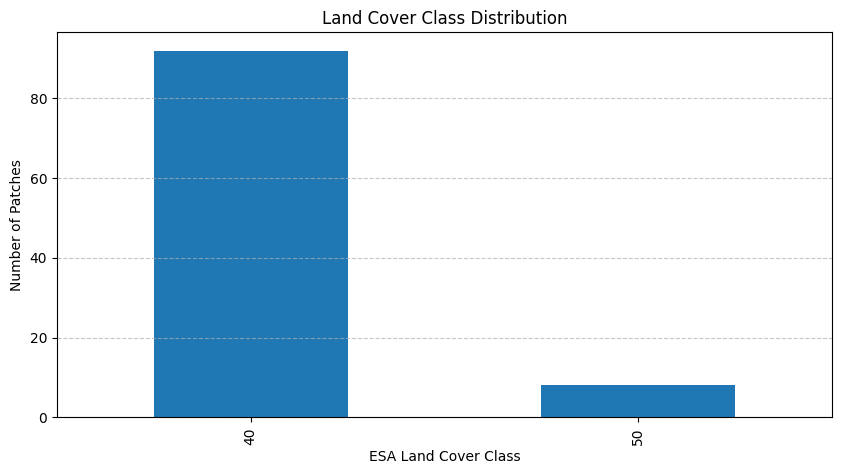

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
labels_df["mode_class"].value_counts().sort_index().plot(kind="bar")
plt.title("Land Cover Class Distribution")
plt.xlabel("ESA Land Cover Class")
plt.ylabel("Number of Patches")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
